# power forecasting

### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain

from xgboost import XGBRegressor

In [ ]:
# defining plot params
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

### Importing data

In [ ]:
df = pd.read_csv('data/NLTP_F_DAILY_Makkah.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])
df.index = pd.to_datetime(df.index)
df=df.resample('1M').mean()
df.head()
df['Date']=df.index


C:\Users\Admin\AppData\Local\Temp\ipykernel_1432\3795244070.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df=df.resample('1M').mean()


In [ ]:
df

,System_City_Calculated,Date
Date,,
2011-01-31,1017.645161,2011-01-31
2011-02-28,1171.178571,2011-02-28
2011-03-31,1292.741935,2011-03-31
2011-04-30,1713.233333,2011-04-30
2011-05-31,2094.870968,2011-05-31
...,...,...
2021-06-30,2982.666667,2021-06-30
2021-07-31,2868.161290,2021-07-31
2021-08-31,2983.580645,2021-08-31


Here we have a time series with Date and power features

### Converting Dates into datetime format

We need to convert each date into datetime format (for future simplicity)

In [ ]:
df.Date.head()

Date
2011-01-31   2011-01-31
2011-02-28   2011-02-28
2011-03-31   2011-03-31
2011-04-30   2011-04-30
2011-05-31   2011-05-31
Freq: M, Name: Date, dtype: datetime64[ns]

### Plotting a Time Series

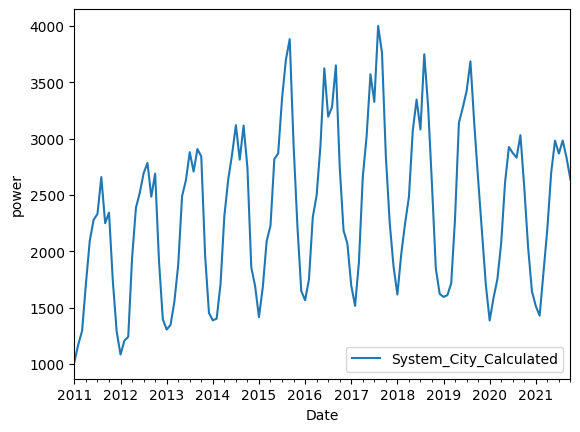

In [ ]:
# Plotting power by Date
df.plot.line(x="Date", y="System_City_Calculated")

plt.ylabel("power")
plt.show()

Here we can see some annual seasonality and probably a trend

### Testing for Stationarity

We need to check if our Time Series is stationary or not, because many useful analytical tools and statistical tests and models rely on it

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=(df["System_City_Calculated"])

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(power):
    result=adfuller(power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [ ]:
adfuller_test(df["System_City_Calculated"])

ADF Test Statistic : -2.236404632429118
p-value : 0.19329890019961904
#Lags Used : 12
Number of Observations Used : 117
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Time Series trend

Here we explore trend in a given Time Series

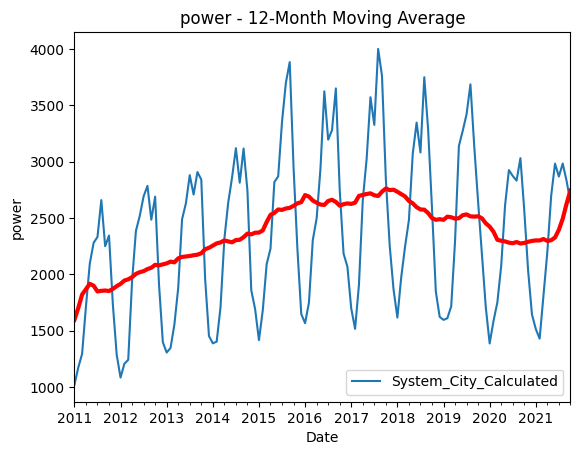

In [ ]:
# Creating Moving Average with 12 month window
moving_average = df.set_index("Date").rolling(
    window=12,
    center=True,
    min_periods=6
).mean()

ax = df.plot.line(x="Date", y="System_City_Calculated")
moving_average.plot(
    ax=ax, linewidth=3, title="power - 12-Month Moving Average",
    legend=False, color='red'
)

plt.ylabel("power")
plt.show()

Time Series definitely has a trend and it seems to be qubic

### Predicting Trend using Deterministic Process

Now I will try to predict a future trend by using Linear Regression

In [ ]:
dp = DeterministicProcess(
    index=df.Date, # dates from the training data
    constant=True, # dummy feature for the bias (y_intercept)
    order=3, # the time dummy (trend) - qubic in our case
    drop=True # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X=dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
Date,,,,
2011-01-31,1.0,1.0,1.0,1.0
2011-02-28,1.0,2.0,4.0,8.0
2011-03-31,1.0,3.0,9.0,27.0
2011-04-30,1.0,4.0,16.0,64.0
2011-05-31,1.0,5.0,25.0,125.0


In [ ]:
y = df['System_City_Calculated']

model = LinearRegression(fit_intercept=False)
# Fit linear regression
model.fit(X, y)

# Make predictions on the training data
y_pred = pd.Series(model.predict(X), index=X.index)

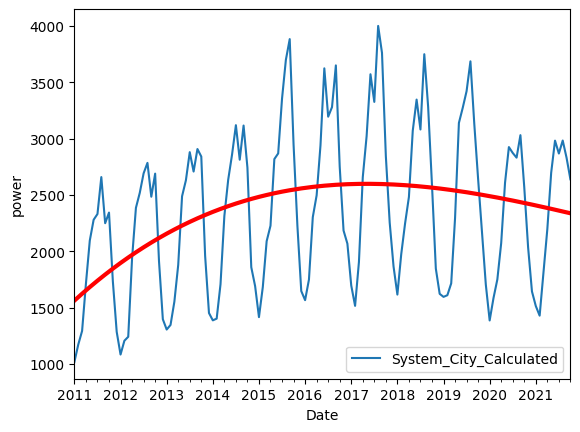

In [ ]:
# Plotting predictions
ax = df.plot.line(x="Date", y="System_City_Calculated")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='red')

plt.ylabel("power")
plt.show()

In [ ]:
from pandas.tseries.offsets import DateOffset

# Create future Dates for forecasting
future_dates = [dp.index[-1] + DateOffset(months=x) for x in range(1,121)]

In [ ]:
# Making a forecast

X = dp.out_of_sample(steps=120)
y_fore = pd.Series(model.predict(X), index=future_dates)

y_fore.head()

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2021-11-30    2329.685851
2021-12-31    2321.617660
2022-01-31    2313.512208
2022-02-28    2305.373497
2022-03-31    2297.205530
dtype: float64

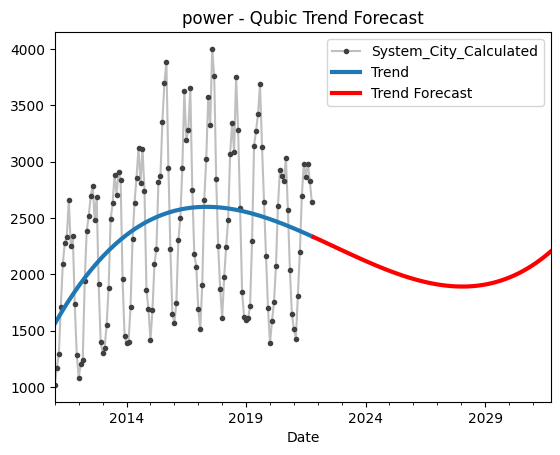

In [ ]:
# Plotting results of a forecast

ax = df.plot.line(x="Date", y="System_City_Calculated", title="power - Qubic Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="red")
_ = ax.legend()

plt.show()

### Time Series Seasonality

Now it's time to explore seasonality in a given Time Series

#### Plotting a Time Series Month-wise in 2011-2013

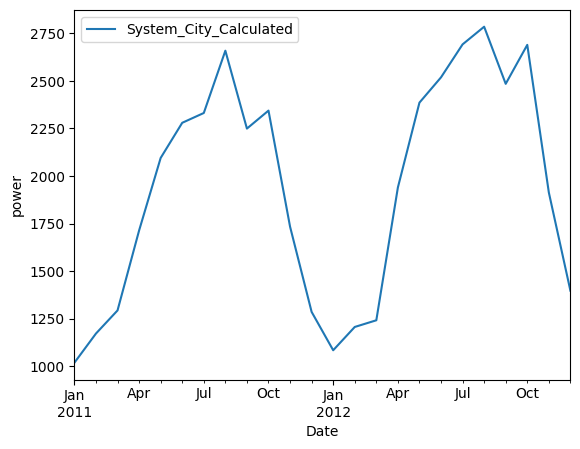

In [ ]:
df.iloc[:24, :].plot.line(x="Date", y="System_City_Calculated")

plt.ylabel("power")
plt.show()

it rocket from september to december (probably because of Christmas holidays) and then fall off. So there is a clear annual seasonality.

### Making Seasonal Forecast

Let's use Linear Regression in order to make a forecast by using trend and seasonality

In [ ]:
dp = DeterministicProcess(
    index=df.Date,
    constant=True,
    order=3,
    period=12,
    seasonal=True,
    drop=True
)

X = dp.in_sample()

In [ ]:
# Target Feature
y = df.System_City_Calculated

# Linear Regression model
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

# Prediction on Training Data
y_pred = pd.Series(model.predict(X), index=df.Date)

# Future forecast for 12 months
X_fore = dp.out_of_sample(steps=120)
y_fore = pd.Series(model.predict(X_fore), index=future_dates)

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


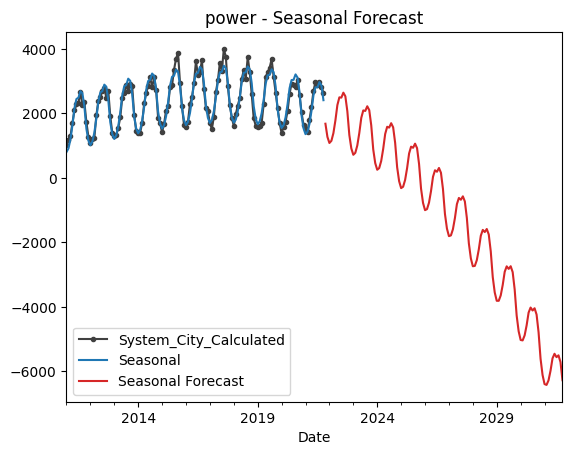

In [ ]:
# Plotting results

ax = df.plot(x="Date", y="System_City_Calculated", color='0.25', style='.-', title="power - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()


plt.show()

It did a good job in fitting training data and a future forecast seems reasonable

## Forecasting

Now let's make a forecast by using different approaches: <br> 1) By using Classical TS model (in our case it's SARIMA, because our TS has a seasonality pattern) <br> 2) By using ML model, in our case it's XGB regressor

### 1-st Approach: Classical TS model (SARIMA)

Firstly we need to make our data stationary

In [ ]:
# Differencing by 12 moths

df["Seasonal_Difference"] = df["System_City_Calculated"] - df["System_City_Calculated"].shift(12)

In [ ]:
df.head(15)

,System_City_Calculated,Date,Seasonal_Difference
Date,,,
2011-01-31,1017.645161,2011-01-31,NaN
2011-02-28,1171.178571,2011-02-28,NaN
2011-03-31,1292.741935,2011-03-31,NaN
2011-04-30,1713.233333,2011-04-30,NaN
2011-05-31,2094.870968,2011-05-31,NaN
2011-06-30,2279.766667,2011-06-30,NaN
2011-07-31,2331.322581,2011-07-31,NaN
2011-08-31,2659.032258,2011-08-31,NaN
2011-09-30,2249.300000,2011-09-30,NaN


In [ ]:
adfuller_test(df["Seasonal_Difference"].dropna())

ADF Test Statistic : -1.781931210135937
p-value : 0.389468523036971
#Lags Used : 13
Number of Observations Used : 104
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


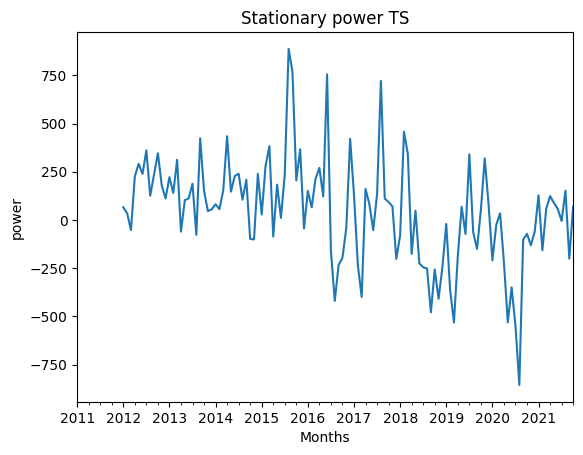

In [ ]:
df.Seasonal_Difference.plot(title="Stationary power TS")

plt.xlabel("Months")
plt.ylabel("power")
plt.show()

### SARIMA Model

For SARIMA Model we need to choose parameters p, d, q, s. For that we need to use ACF and PACF plots

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


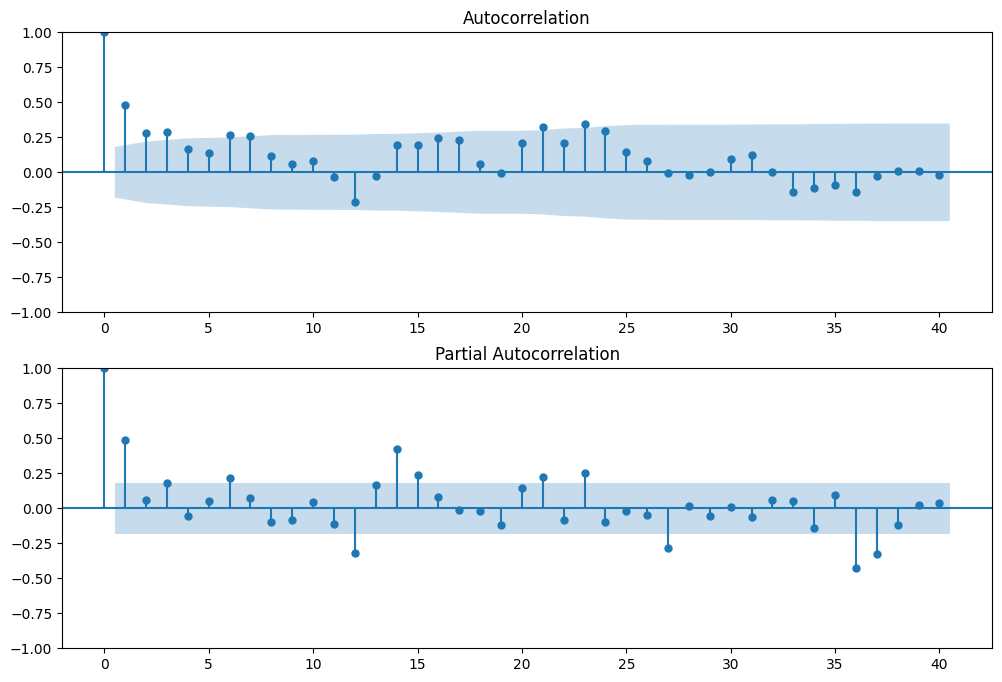

In [ ]:
# Plotting ACF and PACF plots

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal_Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal_Difference'].iloc[13:],lags=40,ax=ax2)

plt.show()

After looking at plots, we conclude: q = 1, d = 1, q = 1, s = 12

In [ ]:
# Initializing SARIMA model
model = sm.tsa.statespace.SARIMAX(
    df["System_City_Calculated"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

# Fitting model
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             System_City_Calculated   No. Observations:                  130
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -795.262
Date:                            Sun, 04 Dec 2022   AIC                           1600.523
Time:                                    21:17:35   BIC                           1614.334
Sample:                                01-31-2011   HQIC                          1606.130
                                     - 10-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2101      0.110      1.902      0.057      -0.006       0.427
ma.L1         -0.8793      0.061    -14.530      0.000      -0.998      -0.761
ar.S.L12      -0.4815      0.185     -2.608      0.009      -0.843      -0.120
ma.S.L12       0.0725      0.204      0.356      0.722      -0.326       0.471
sigma2       4.56e+04   5556.648      8.206      0.000    3.47e+04    5.65e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.90   Prob(JB):                         0.25
Heteroskedasticity (H):               1.94   Skew:                             0.24
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

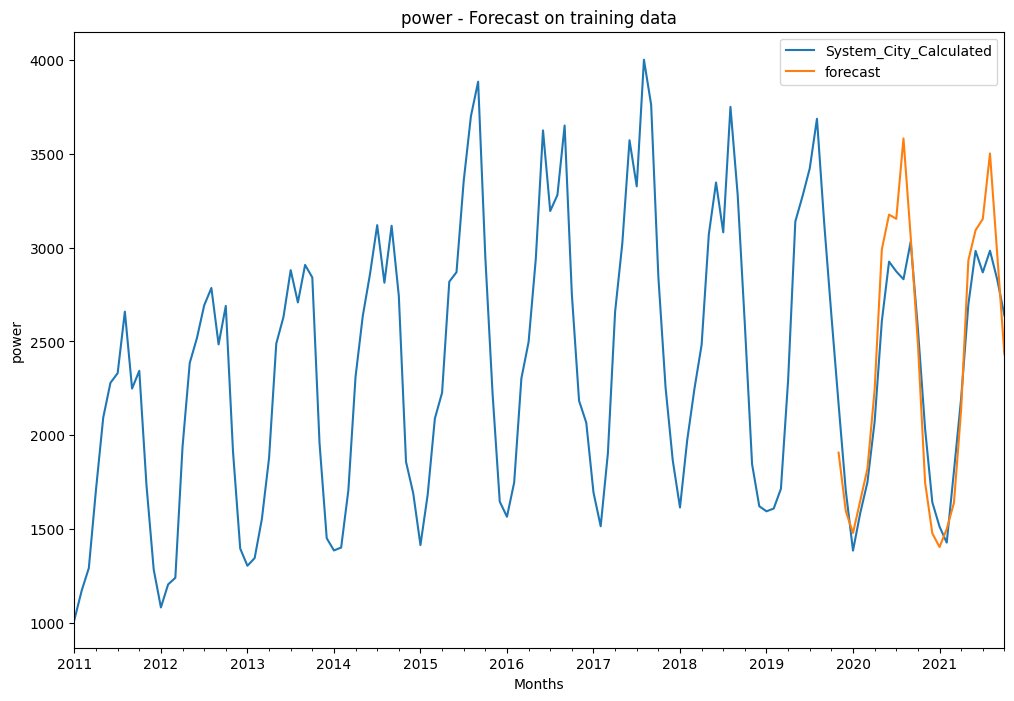

In [ ]:
# Making forecast on training data
df['forecast'] = model_fit.predict(start=106, end=130, dynamic=True)

# Plotting results
df[['System_City_Calculated','forecast']].plot(figsize=(12,8))

plt.xlabel("Months")
plt.ylabel("power")
plt.title("power - Forecast on training data")

plt.show()

Model did a good job in fitting a training Data

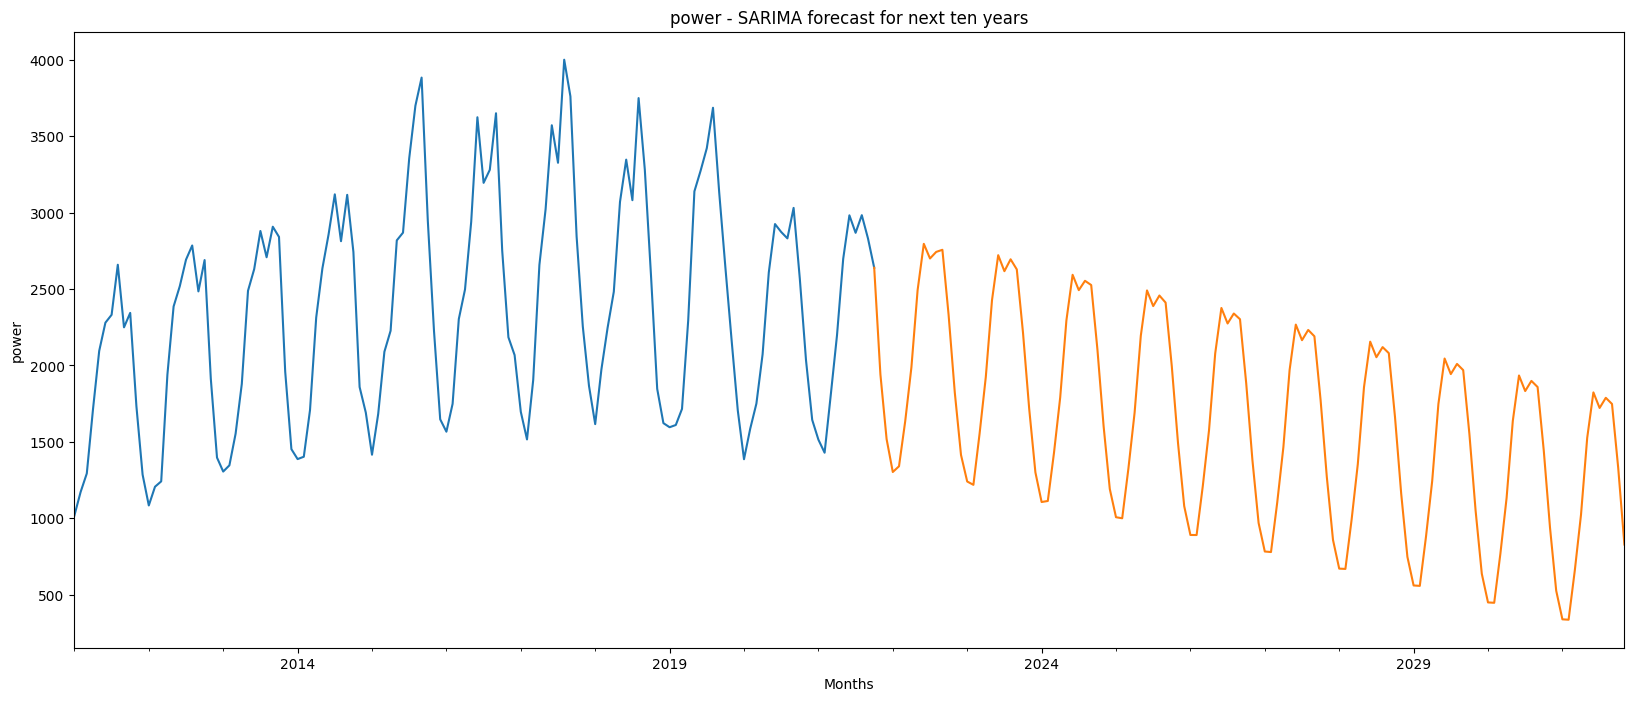

In [ ]:
df_future = model_fit.predict(start=129, end=250, dynamic=True)
df_future[0]=df["System_City_Calculated"][-1]
df['System_City_Calculated'].plot(figsize=(20, 8))
df_future.plot(figsize=(20, 8))
plt.title("power - SARIMA forecast for next ten years")
plt.xlabel("Months")
plt.ylabel("power")

plt.show()

In [ ]:
df_future.resample('1Y').mean()

2021-12-31    2032.866987
2022-12-31    2109.872570
2023-12-31    2021.199318
2024-12-31    1899.726548
2025-12-31    1794.046329
2026-12-31    1680.762198
2027-12-31    1571.139254
2028-12-31    1459.753495
2029-12-31    1349.216508
2030-12-31    1238.270849
2031-12-31    1192.355102
Freq: A-DEC, Name: predicted_mean, dtype: float64

The forecast seems reasonable, even though it doesn't follow previously predicted trend